In [6]:
from io import StringIO
import geopandas as gpd
import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from pathlib import Path
from requests import get
from shapely.ops import cascaded_union
import yaml
import requests_cache

requests_cache.install_cache('demo_cache')

In [10]:
config = lambda:yaml.safe_load(Path("mappe.yaml").read_text()) 
maps = lambda:config()['maps']

In [408]:
europe =  config()['europe_borders']
eu_area = gpd.read_file(StringIO(json.dumps(europe)))
eu_area = eu_area.set_crs("EPSG:4326")
europe

{'geometry': {'type': 'Polygon',
  'coordinates': [[[-11.0, 34.0],
    [-11.0, 62.0],
    [35.0, 62.0],
    [35.0, 34.0],
    [-11.0, 34.0]]]},
 'properties': {'name': 'Europe Borders'}}

In [499]:
from shapely.geometry import Polygon, MultiPolygon


def filter_noise(shape : MultiPolygon):
    return MultiPolygon([p for p in shape if p.area > 1_010_202_521 ])

def togli_isolette(area, base=1):
    for i, poli in enumerate(list(area.geometry)):
        if isinstance(poli, MultiPolygon):
            area.geometry[i] = MultiPolygon(
                [k for k in poli if k.area > base]
            )

def get_polygons(label):
    """
    Si collega ad internet e scarica i poligoni associati alla label.
    """
    coord_type = 3857
    coord_type = 4326
    base = "https://gisco-services.ec.europa.eu/distribution/v2"
    
    if isinstance(label, int):
        return get(f'http://polygons.openstreetmap.fr/get_geojson.py?id={label}&params=0')
    
    if label.startswith("http"):
        return get(label)
    
    
    for db, year in (("nuts",2021), ("countries", 2020)):
        ret = get(
            f"{base}/{db}/distribution/{label}-region-10m-{coord_type}-{year}.geojson"
        )
        if ret.status_code == 200:
            break
        print(f'cannot find {ret.url}')
    return ret


def area_frame(label):
    return gpd.read_file(get_polygons(label).content.decode())


def join_areas(areas):
    area_frames = [area_frame(label) for label in areas]
    ret = gpd.GeoSeries(cascaded_union([x.geometry[0] for x in area_frames]))
    #ret = ret.set_crs("EPSG:4326")
    return ret # .to_crs("EPSG:4326")



def get_state(state):
    territori = maps()[state]['territori']
    return {k:join_areas(v) for k,v in territori.items()}

def get_state_df(state):
    territori = list(get_state(state).items())
    n, s = territori[0]

    df = DataFrame({"name": [n]})
    ret=gpd.GeoDataFrame(df,geometry=s)
    for n, s in territori[1:]:
        ret = ret.append(
            gpd.GeoDataFrame(
                DataFrame({"name":[n]}),
                geometry=s
            )
        )
    
    ret = ret.set_crs("EPSG:4326")
    ret = ret.to_crs(epsg=3857)
    #togli_isolette(ret,100_000_000_000)

#    ret = ret.intersection(eu_area)
    return ret
    
def render(gdfm, facecolor1="blue", facecolor2="blue", edgecolor="white", ax=None):
    
    for name in gdfm.name:
        t = gdfm[gdfm.name == name]
        print(t, name)
        t=t.intersection(eu_area.to_crs("EPSG:3857"))

        #togli_isolette(t, 1)
        t.plot(ax=ax, edgecolor="white", facecolor=facecolor1,  linewidth=2)
        t.plot(ax=ax, edgecolor="white", facecolor=facecolor2,  linewidth=0, alpha=0.5)  
        #t.plot(edgecolor=edgecolor, facecolor="none", ax=ax)

def render_state(state, ax):
    state_area = get_state_df(state)
    color_config =  maps()[state]['config']
    render(state_area, ax=ax, **color_config)
    return state_area
%matplotlib qt
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


In [500]:
FR = get_state_df('France')

In [508]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1,1)
render_state("Indipendenti", ax)


       name                                           geometry
0  Svizzera  POLYGON ((965191.192 6054585.988, 979133.958 6... Svizzera
       name                                           geometry
0  Portugal  MULTIPOLYGON (((-1764988.338 3521629.059, -176... Portugal
    name                                           geometry
0  Spain  MULTIPOLYGON (((-1990978.036 3225227.713, -199... Spain
      name                                           geometry
0  Denmark  MULTIPOLYGON (((1650355.979 7411338.742, 16635... Denmark
     name                                           geometry
0  Sweden  MULTIPOLYGON (((1230245.126 8153168.688, 12291... Sweden
     name                                           geometry
0  Norway  MULTIPOLYGON (((531616.247 8550779.462, 528041... Norway
      name                                           geometry
0  Finland  MULTIPOLYGON (((2375280.748 8354739.940, 23774... Finland


,name,geometry
0,Svizzera,"POLYGON ((965191.192 6054585.988, 979133.958 6..."
0,Portugal,"MULTIPOLYGON (((-1764988.338 3521629.059, -176..."
0,Spain,"MULTIPOLYGON (((-1990978.036 3225227.713, -199..."
0,Denmark,"MULTIPOLYGON (((1650355.979 7411338.742, 16635..."
0,Sweden,"MULTIPOLYGON (((1230245.126 8153168.688, 12291..."
0,Norway,"MULTIPOLYGON (((531616.247 8550779.462, 528041..."
0,Finland,"MULTIPOLYGON (((2375280.748 8354739.940, 23774..."


       name                                           geometry
0  Piemonte  POLYGON ((1024473.274 5560875.694, 1056796.001... Piemonte
              name                                           geometry
0  Lombardo Veneto  MULTIPOLYGON (((1386411.900 5690836.401, 13838... Lombardo Veneto
      name                                           geometry
0  Sicilia  MULTIPOLYGON (((1407113.986 4234843.291, 14068... Sicilia
              name                                           geometry
0  Regno di Napoli  MULTIPOLYGON (((1586432.988 4945278.969, 15791... Regno di Napoli
   name                                           geometry
0  Roma  POLYGON ((1486980.155 5265521.507, 1491825.892... Roma
         name                                           geometry
0  Granducati  MULTIPOLYGON (((1151150.402 5209256.393, 11456... Granducati
        name                                           geometry
0  Occitanie  MULTIPOLYGON (((-12432.161 5362693.442, -8543.... Occitanie
       name        

GEOSException: TopologyException: Input geom 0 is invalid: Self-intersection at or near point 3555464.4702469874 6452251.0644109268 at 3555464.4702469874 6452251.0644109268

In [40]:
help(plt.subplots)

Help on function subplots in module matplotlib.pyplot:

subplots(nrows=1, ncols=1, *, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, **fig_kw)
    Create a figure and a set of subplots.
    
    This utility wrapper makes it convenient to create common layouts of
    subplots, including the enclosing figure object, in a single call.
    
    Parameters
    ----------
    nrows, ncols : int, default: 1
        Number of rows/columns of the subplot grid.
    
    sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
        Controls sharing of properties among x (*sharex*) or y (*sharey*)
        axes:
    
        - True or 'all': x- or y-axis will be shared among all subplots.
        - False or 'none': each subplot x- or y-axis will be independent.
        - 'row': each subplot row will share an x- or y-axis.
        - 'col': each subplot column will share an x- or y-axis.
    
        When subplots have a shared x-axis along a column, on

### import contextily as ctx


In [352]:
r =get_state('Russia')

cannot find https://gisco-services.ec.europa.eu/distribution/v2/nuts/distribution/BY-region-10m-4326-2021.geojson


cannot find https://gisco-services.ec.europa.eu/distribution/v2/nuts/distribution/BY-region-10m-4326-2021.geojson


,name,geometry
0,Mosca,"MULTIPOLYGON (((3511245.345 6885957.914, 35109..."
0,San Pietroburgo,"POLYGON ((3448539.421 7753968.430, 3449236.682..."
0,Baltici,"MULTIPOLYGON (((2672901.199 7991632.361, 26678..."
0,Ucraina,"MULTIPOLYGON (((3922166.407 5747036.360, 39229..."
0,Belarus,"POLYGON ((3538499.296 6820302.184, 3497513.685..."


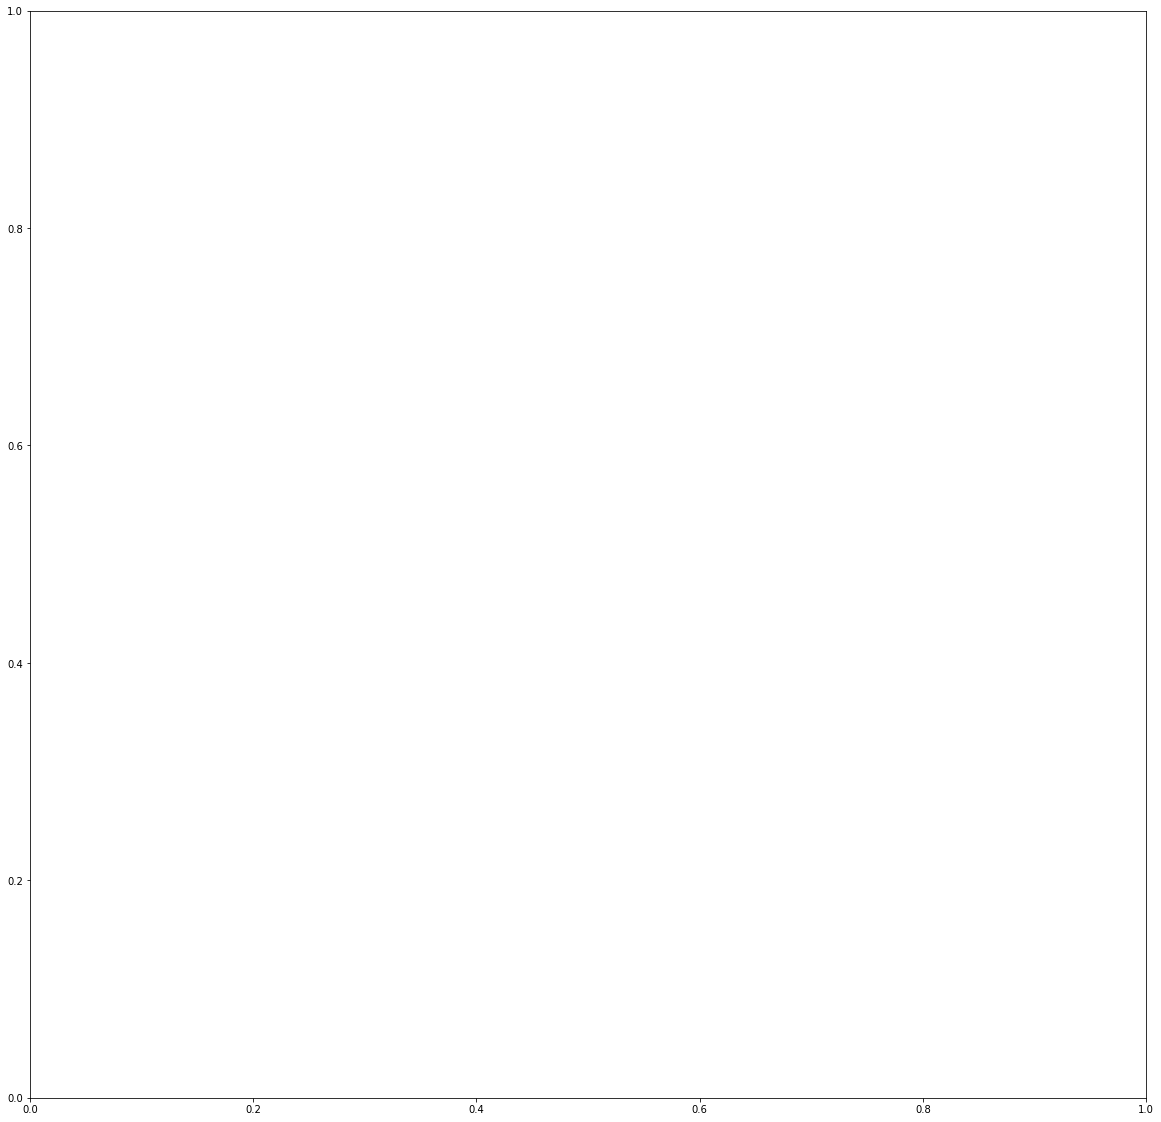

In [387]:
%matplotlib inline

R=get_state_df("Russia")
R.head()

/home/rpolli/.local/lib/python3.7/site-packages/geopandas/base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


<AxesSubplot:>

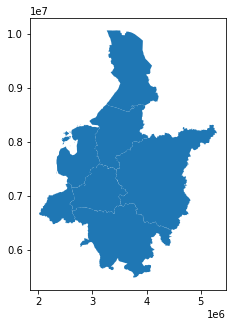

In [406]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(5,5)
#EPSG:3857, EPSG:4326
R.head()
R.to_crs("EPSG:4326").intersection(eu_area)
#eu_area.plot(alpha=0.4,ax=ax1)
R.plot(ax=ax1)

In [512]:
R=get_state_df('Italia').to_crs(epsg=3857)
R.plot(ax=ax1, alpha=0.4, linewidth=3, edgecolor="white", facecolor="red"
      )
import contextily as ctx
ctx.add_basemap(ax1)

In [56]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(20,20)

I = get_state_df('Ottomano')
I.plot()
import contextily as ctx
ctx.add_basemap(ax1)

/home/rpolli/.local/lib/python3.7/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


In [266]:

def filtra(area, base):
    print(id(area))
    entity = getattr(area, 'geometry', area)
    for i, poli in enumerate(entity):
        if isinstance(poli, MultiPolygon):
            print(i, max(k.area for k in poli))
            entity[i] = MultiPolygon([k for k in poli if k.area > base])
        if isinstance(poli, Polygon):
            print("poli", i, poli.area)
#filtra(uk, 139686868885072)
uk = get_state_df('Regno Unito')
for i, e in enumerate(uk.geometry):
    print(i, e.__class__)



0 <class 'shapely.geometry.multipolygon.MultiPolygon'>
1 <class 'shapely.geometry.multipolygon.MultiPolygon'>
2 <class 'shapely.geometry.polygon.Polygon'>
3 <class 'shapely.geometry.multipolygon.MultiPolygon'>
4 <class 'shapely.geometry.multipolygon.MultiPolygon'>


In [457]:
ret=get_state_df('Regno Unito')
ret.geometry

KeyError: 1

Scotland
Wales
Yorkshire
London
Ireland
139686838039760
0 4.37417302135


<AxesSubplot:>

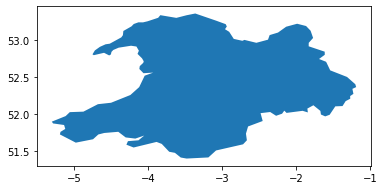

In [447]:
for x in ret.name: print(x)
x='Wales'
c=ret[ret.name == x]
filtra(c, 1)
c.plot()

In [371]:
R=get_state_df("Russia")
R.intersection(eu_area.to_crs("E"))
R.plot()

cannot find https://gisco-services.ec.europa.eu/distribution/v2/nuts/distribution/BY-region-10m-4326-2021.geojson


/home/rpolli/.local/lib/python3.7/site-packages/geopandas/base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/home/rpolli/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3857
Right CRS: EPSG:4326

  


<AxesSubplot:>

In [316]:
uk[0].to_frame()

,name,0
0,London,NaN
1,Scotland,NaN
0,NaN,"(POLYGON ((-7.60708 56.7999, -7.65762 56.78659..."
